# PSTAT 134 Final Project: Recommending Restaurants

**Contributors:**
- Anthony Cu
- Christina Cui
- Nathan Landeza
- William Mahnke
- Anna Maximova 

**Table of Contents**

- [Introduction](##Introduction)
- [Data Collection](##Data-Collection)
- [Data Cleaning](##Data-Cleaning)
    - [Feature Engineering](###Feature-Engineering)
    - [Data Visualization](###Data-Visualization)
- [Recommender Systems](##Recommender-Systems)
    - [Bag of Words Recommender](###Bag-of-Words-Recommender)
    - [TF-IDF Recommender](###TF-IDF-Recommender)
- [Conclusion](#conclusion)

## Introduction

The goal of this project was to build a system to recommend a restaurant given different preferences from a user. For this project we narrowed our data to restaurants found in Isla Vista and the general Santa Barbara area, with the data being accessed using [**Yelp Fusion API**](https://docs.developer.yelp.com/docs/fusion-intro). After retrieving and preprocessing the data, we created 2 recommender systems:
- bag of words vectorizer
- Tf-IDF vectorizer 

. The intent for the recommender systems is to:
1. Recommend restaurants given a particular cuisine from the user
2. Recommend restaurants similar to a restaurant given by the user

In [8]:
from flask import Flask, render_template, request  # Import Flask and related modules for web handling
import requests  # Import requests library to make HTTP requests
import http.client
from google.colab import files
import json
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

## Data Collection

To access Yelp Fusion API, one of our group members created a membership to access the one-month free trial. The API request restricted the number of restaurants per request to 50 which motivated us to narrow the scope to the Isla Vista and general Santa Barbara area. To process the data from the API request, we created a helper function `get_restaurants` to extract the desired information and convert the data into a .csv file.

With the API call, we were able to access information about up to 50 restaurants based on inputting the location/city name. Information we retrived included: name, Yelp's unique business ID, number of reviews, average rating (1-5), cuisine descriptions, price range, takeout availabilty, waitlist requisite, business hours (per day), geographic features, and link to the restaurant website (if available). 

In [ ]:
# Yelp API credentials
client_id = 'fOg_XdQrnZ96u3gwOQFPdw'
api_key = 'f-KxAdzDk5nbXKT9P9hBfefO7kpRW7EHFSxnxSNMF3AZJ5thYkeQBQRQ_sIDnEGCoafODEHteG2imdncOWZB72MAUWlTR5YLI6u5EOcaqtD15YpKS_GGDr9PxMIeZ3Yx'

# Yelp API endpoint for searching businesses
url = 'https://api.yelp.com/v3/businesses/search'

In [ ]:
# function to return a dataframe of 50 restaurants in area
def get_restaurants(city, term='restaurants', limit = 50):
    # Construct the Yelp API URL
    url = 'https://api.yelp.com/v3/businesses/search'

    # Set up the headers for authentication
    headers = {
        'Authorization': f'Bearer {api_key}'
    }

    # Define the parameters for the request
    params = {
        'location': city,
        'term': term,
        'limit': limit
    }

    # Send a GET request to the Yelp API
    response = requests.get(url, headers=headers, params=params)

    # Check if the response was successful
    if response.status_code == 200:
        # Return the JSON data AS A DATAFRAME if the request was successful
        response_data = response.json()

        restaurants_df = pd.DataFrame()
        for i in range(len(response_data['businesses'])):
          # input restaurant information
          restaurants_df.loc[i, 'Business_ID'] = response_data['businesses'][i].get('id', None)
          restaurants_df.loc[i, 'Name'] = response_data['businesses'][i].get('name', None)
          restaurants_df.loc[i, 'NumReviews'] = response_data['businesses'][i].get('review_count', None)
          restaurants_df.loc[i, 'Rating'] = response_data['businesses'][i].get('rating', None)

          # input information from categories tab
          categories = response_data['businesses'][i].get('categories', [])
          if len(categories) > 0:
            restaurants_df.loc[i, 'Cuisine'] = categories[0]['title']
          if len(categories) > 1:
            restaurants_df.loc[i, 'Cuisine1'] = categories[1]['title']
          if len(categories) > 2:
            restaurants_df.loc[i, 'Cuisine2'] = categories[2]['title']

          restaurants_df.loc[i, 'PriceRange'] = response_data['businesses'][i].get('price', None)
          restaurants_df.loc[i, 'Takeout'] = ', '.join(response_data['businesses'][i].get('transactions', [])) # rewrite list as string
          restaurants_df.loc[i, 'Waitlist_Needed'] = response_data['businesses'][i].get('attributes', {}).get('waitlist_reservation', None)

          # business hours (check if any open hours)
          business_hours = response_data['businesses'][i].get('business_hours', [])
          if business_hours:
              open_hours = business_hours[0].get('open', [])
          else:
              open_hours = []
          days = ['Su', 'M', 'T', 'W', 'R', 'F', 'Sa']

          for j in range(7):
              if j < len(open_hours):
                  restaurants_df.loc[i, f'{days[j]}_start'] = open_hours[j].get('start', None)
                  restaurants_df.loc[i, f'{days[j]}_end'] = open_hours[j].get('end', None)
              else:
                  restaurants_df.loc[i, f'{days[j]}_start'] = None
                  restaurants_df.loc[i, f'{days[j]}_end'] = None

          restaurants_df.loc[i, 'Latitude'] = response_data['businesses'][i].get('coordinates', {}).get('latitude', None)
          restaurants_df.loc[i, 'Longitude'] = response_data['businesses'][i].get('coordinates', {}).get('longitude', None)
          restaurants_df.loc[i, 'Address'] = response_data['businesses'][i].get('location', {}).get('address1', None)
          restaurants_df.loc[i, 'City'] = response_data['businesses'][i].get('location', {}).get('city', None)
          restaurants_df.loc[i, 'State'] = response_data['businesses'][i].get('location', {}).get('state', None)
          restaurants_df.loc[i, 'Zip'] = response_data['businesses'][i].get('location', {}).get('zip_code', None)
          restaurants_df.loc[i, 'Menu'] = response_data['businesses'][i].get('attributes', {}).get('menu_url', None)

        return restaurants_df
    else:
        # Return None if there was an error
        return None

After extracting data from the API, we stored these data as .csv files based on their location (Isla Vista, Santa Barbara).

## Data Cleaning
### Feature Engineering
After accessing the restaurant information, we proceeded with data cleaning and feature engineering. We preprocessed our data to create variables that would be util to the recommender systems. Some of the new features include:

- `takeout_options_encoded`: the `Takeout` variable was initially storing a string of words based on the available takeout options such as "pickup", "delivery", etc; we one-hot encoded these categories to create new columns for each takeout options with 0/1 denoting wheter or not the restaurant offers the service
- `price_descrip`: to translate the orginal `PriceRange` metric (which was based on the number of $s) into English words- making it more accessible for Natural Lanugage Processing
- `day_meal`: to convert the by-day open hours into standard meal time (breakfast, lunch, dinner) offerings for each day (Sunday- Saturday); we assumed breakfast to be 7am-10am; lunch to be from 11am-2pm; and dinner to be from 5pm-9pm

In [ ]:
restaurants = pd.concat([iv, sb], ignore_index=True)

In [ ]:
# string split takeouts into list objects
restaurants['Takeout'] = restaurants['Takeout'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# one-hot encode takeout cateogires
takeout_encoded = restaurants['Takeout'].apply(lambda x: pd.Series(1, index=x)).fillna(0)

restaurants = pd.concat([restaurants, takeout_encoded], axis=1)

In [ ]:
restaurants['PriceRange'].unique()

def clean_price(x):
    if x == '$':
        return 'cheap' # budget friendly, affordable
    elif x == '$$':
        return 'moderate' # mid-range
    elif x == '$$$':
        return 'high' # high-end, upscale, fine-dining
    elif x == '$$$$':
        return 'expensive' # luxury, premium experience

restaurants['price_descrip'] = restaurants['PriceRange'].apply(clean_price)

In [ ]:
def is_open(start, end, meal_start, meal_end):
    # Normalize start/end times to the range of minutes from midnight
    start_minutes = (start // 100) * 60 + (start % 100)
    end_minutes = (end // 100) * 60 + (end % 100)
    meal_start_minutes = (meal_start // 100) * 60 + (meal_start % 100)
    meal_end_minutes = (meal_end // 100) * 60 + (meal_end % 100)

    # Check if the restaurant's hours overlap with the meal time
    return 1 if (start_minutes < meal_end_minutes and end_minutes > meal_start_minutes) else 0

# Meal time windows (in 24-hour format)
meal_times = {
    'Breakfast': (700, 1000),
    'Lunch': (1100, 1400),
    'Dinner': (1700, 2100)
}

# Apply the function for each day of the week
for day in ['Su', 'M', 'T', 'W', 'R', 'F', 'Sa']:
    for meal, (meal_start, meal_end) in meal_times.items():
        # Create new columns indicating whether the restaurant is open during each meal time
        restaurants[f'{day}_{meal}'] = restaurants.apply(lambda x: is_open(x[f'{day}_start'], x[f'{day}_end'], meal_start, meal_end), axis=1)

restaurants['Cuisine'] = restaurants['Cuisine'].fillna('')
restaurants['Cuisine1'] = restaurants['Cuisine1'].fillna('')
restaurants['Cuisine2'] = restaurants['Cuisine2'].fillna('')
restaurants['Description'] = restaurants['Description'].fillna('')

restaurants['descriptors'] = restaurants.apply(lambda x: str(x['Cuisine']).strip() + ' ' + str(x['Cuisine1']).strip() + ' ' + str(x['Cuisine2']).strip() + ' ' + str(x['Description']).strip(), axis=1)

In [ ]:
# making final data frame
restaurants_cleaned = pd.DataFrame({'business_id': restaurants['Business_ID'],
                                    'name': restaurants['Name'],
                                    'num_reviews': restaurants['NumReviews'],
                                    'rating': restaurants['Rating'],
                                    'descriptors': restaurants['descriptors'],
                                    'price_descrip': restaurants['price_descrip'],
                                    'su_breakfast': restaurants['Su_Breakfast'],
                                    'su_lunch': restaurants['Su_Lunch'],
                                    'su_dinner': restaurants['Su_Dinner'],
                                    'm_breakfast': restaurants['M_Breakfast'],
                                    'm_lunch': restaurants['M_Lunch'],
                                    'm_dinner': restaurants['M_Dinner'],
                                    't_breakfast': restaurants['T_Breakfast'],
                                    't_lunch': restaurants['T_Lunch'],
                                    't_dinner': restaurants['T_Dinner'],
                                    'w_breakfast': restaurants['W_Breakfast'],
                                    'w_lunch': restaurants['W_Lunch'],
                                    'w_dinner': restaurants['W_Dinner'],
                                    'r_breakfast': restaurants['R_Breakfast'],
                                    'r_lunch': restaurants['R_Lunch'],
                                    'r_dinner': restaurants['R_Dinner'],
                                    'f_breakfast': restaurants['F_Breakfast'],
                                    'f_lunch': restaurants['F_Lunch'],
                                    'f_dinner': restaurants['F_Dinner'],
                                    'sa_breakfast': restaurants['Sa_Breakfast'],
                                    'sa_lunch': restaurants['Sa_Lunch'],
                                    'sa_dinner': restaurants['Sa_Dinner'],
                                    'pickup': restaurants['pickup'],
                                    'delivery': restaurants['delivery'],
                                    'restaurant_reservation': restaurants['restaurant_reservation']})

In [4]:
restaurants_cleaned.head()

,business_id,name,num_reviews,rating,descriptors,price_descrip,su_breakfast,su_lunch,su_dinner,m_breakfast,...,r_dinner,f_breakfast,f_lunch,f_dinner,sa_breakfast,sa_lunch,sa_dinner,pickup,delivery,restaurant_reservation
0,j6t0BW13CZOiTfptbJkyUg,Zocalo,128.0,4.8,Mexican Coffee & Tea Breakfast & Brunch,moderate,1,1,1,1,...,1,1,1,1,1,1,1,1.0,1.0,0.0
1,Fz-BIAOoPIzfUj2NdFPEqA,Santa Barbara Fish Market and Restaurant - Goleta,97.0,4.4,Seafood Markets Seafood Fish & Chips,moderate,0,1,1,0,...,1,0,1,1,0,1,1,1.0,1.0,0.0
2,Rl42JbSMsmNW3LRjsTMYAg,Freebirds,1423.0,4.1,Mexican,moderate,0,1,1,0,...,1,0,1,1,0,1,1,0.0,0.0,0.0
3,eGI_WepIIjYahIrMVRknfw,Sizzling Lunch,148.0,4.2,Japanese Steakhouses Asian Fusion,moderate,0,1,1,0,...,1,0,1,1,0,1,1,1.0,1.0,0.0
4,9xW7LsJpyhVZFRb6z9xorg,Ca' Dario - Goleta,282.0,4.0,Italian Pizza Wine Bars,moderate,0,1,1,0,...,1,0,1,1,0,0,1,1.0,1.0,0.0


Our dataset includes:

- `business_id`: Yelp's unique ID for the restaurant
- `name`: restaurant name
- `num_reviews`: number of reviews given for the restaurant on Yelp
- `rating`: average rating (from 1-5)
- `descriptors`: Yelp's cuisine, descriptions for the restaurant combined into one variable for convenient accessing
- `price_descrip`: word description for the restaurant's price range (cheap, moderate, high, expensive)
- `day_mealType`: one-hot encoded variable depicting wheter or not the restauarnt offers this mealType (breakfast, lunch, dinner) on the day
- `pickup`: wheter or not the restaurant offers pickup service
- `delivery`: wheter or not the restaurant offers delivery service
- `restaurant_reservation`: wheter or not the restaurant requires reservation

### Data Visualization
With the data fully cleaned we made visuals of some variables in the dataset to inform our choices when building the recommender systems.

In [ ]:
# plotting revews and num_reviews
plt.figure(figsize = (10,6))

sns.scatterplot(data = restaurants_cleaned, x = 'num_reviews', y = 'rating')

# labeling specific restaurants in the plot
labeled_restaurants = ['Freebirds', 'Teddy Rice', 'Hana Kitchen', "Santa Barbara Shellfish Company"]
for i, row in restaurants.iterrows():
    if row['name'] in labeled_restaurants:
        plt.text(row['num_reviews'], row['rating'], '  ' + row['name'],
                 fontsize = 10, ha = 'left', color = 'black')

plt.title("Overall Impression of Restaurants in the SB/IV Area")
plt.xlabel("Number of Reviews")
plt.ylabel("Rating")

plt.show()

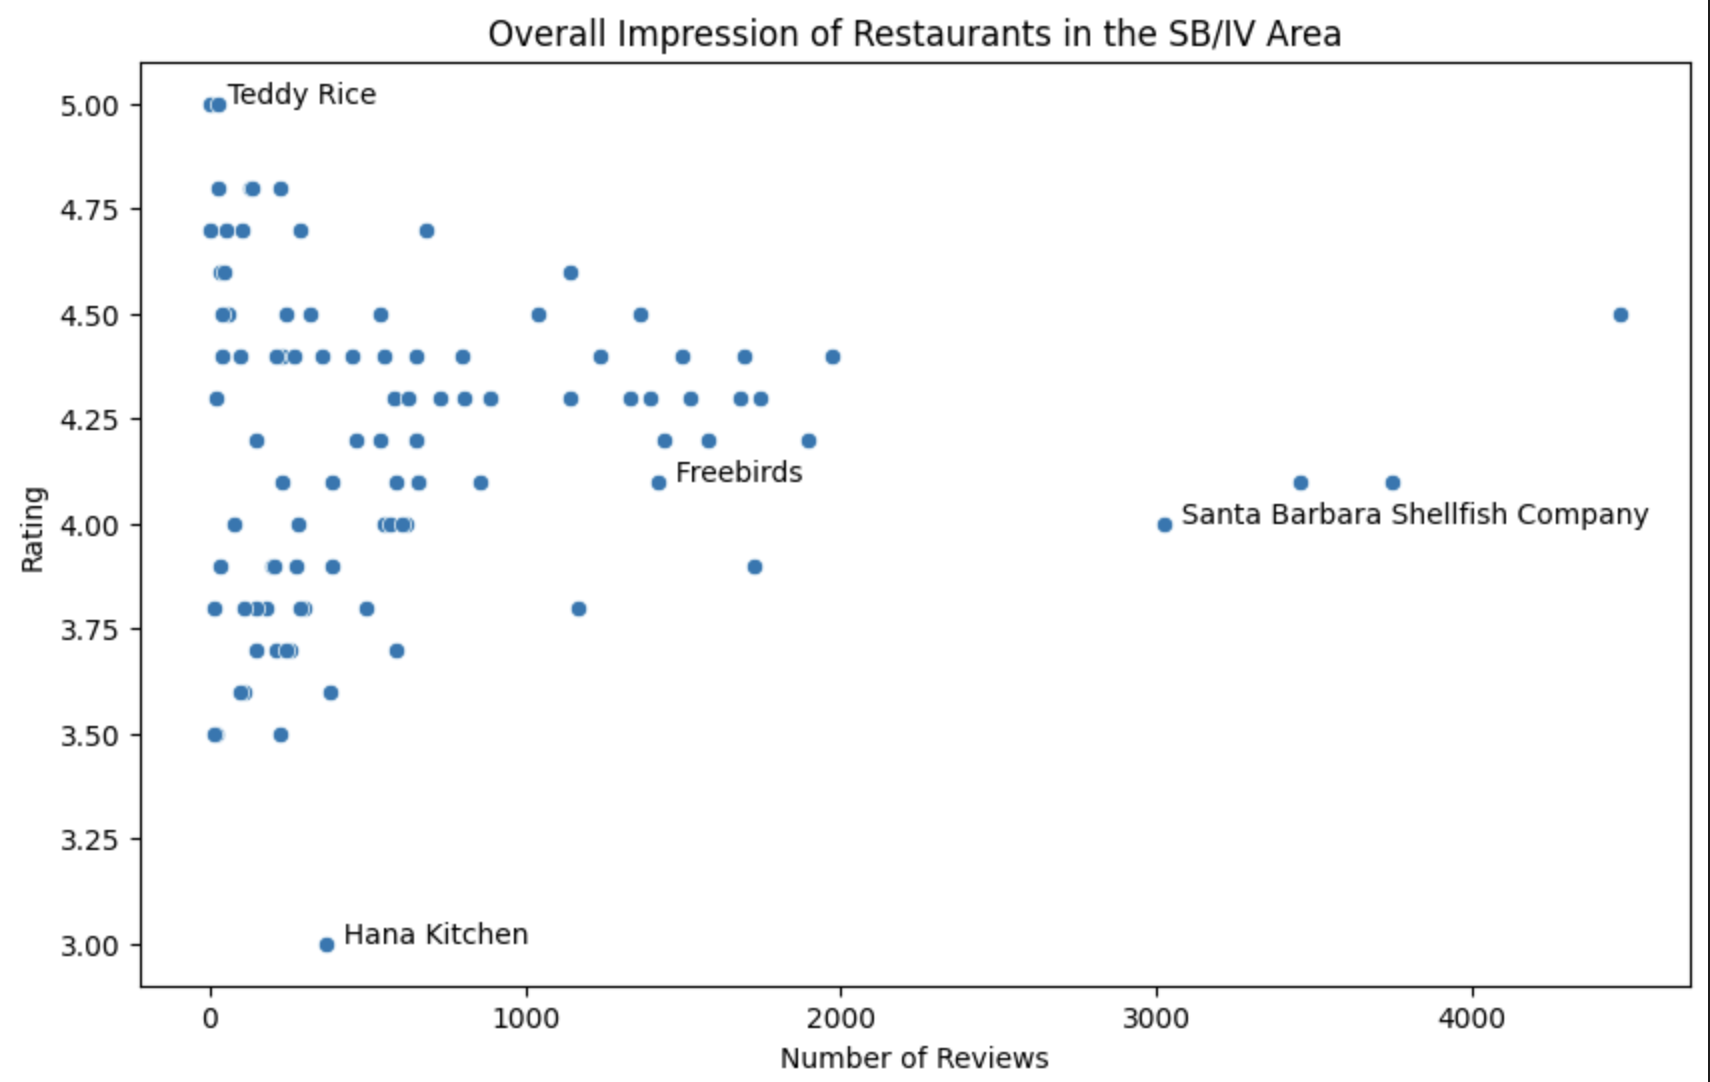

The scatterplot shows a relatively normal distribution of ratings within the data set with a mean of about 4.25. There are some tail values such as Hana Kitchen at 3.0 and a couple of restaurants with Teddy Rice at 5.0, but overall the data set shows a relatively normal distribution of ratings that could be a factor in a recommender system. Additionally, a majority of restaurants have less than 1000 customer reviews. The restaurants with more than 1000 tend to have a rating between 4.0 and 4.5 which suggests they’re very reliable establishments. 

In [ ]:
# plot of most common cuisine types
cuisine_counter = Counter(" ".join(restaurants_cleaned['descriptors'].dropna()).split())
common_cuisines = pd.DataFrame(cuisine_counter.most_common(10), columns=['Cuisine', 'Count'])
common_cuisines.set_index('Cuisine').plot(kind='bar')
plt.title('Top 10 Most Common Cuisine Types')
plt.ylabel('Frequency')
plt.show()

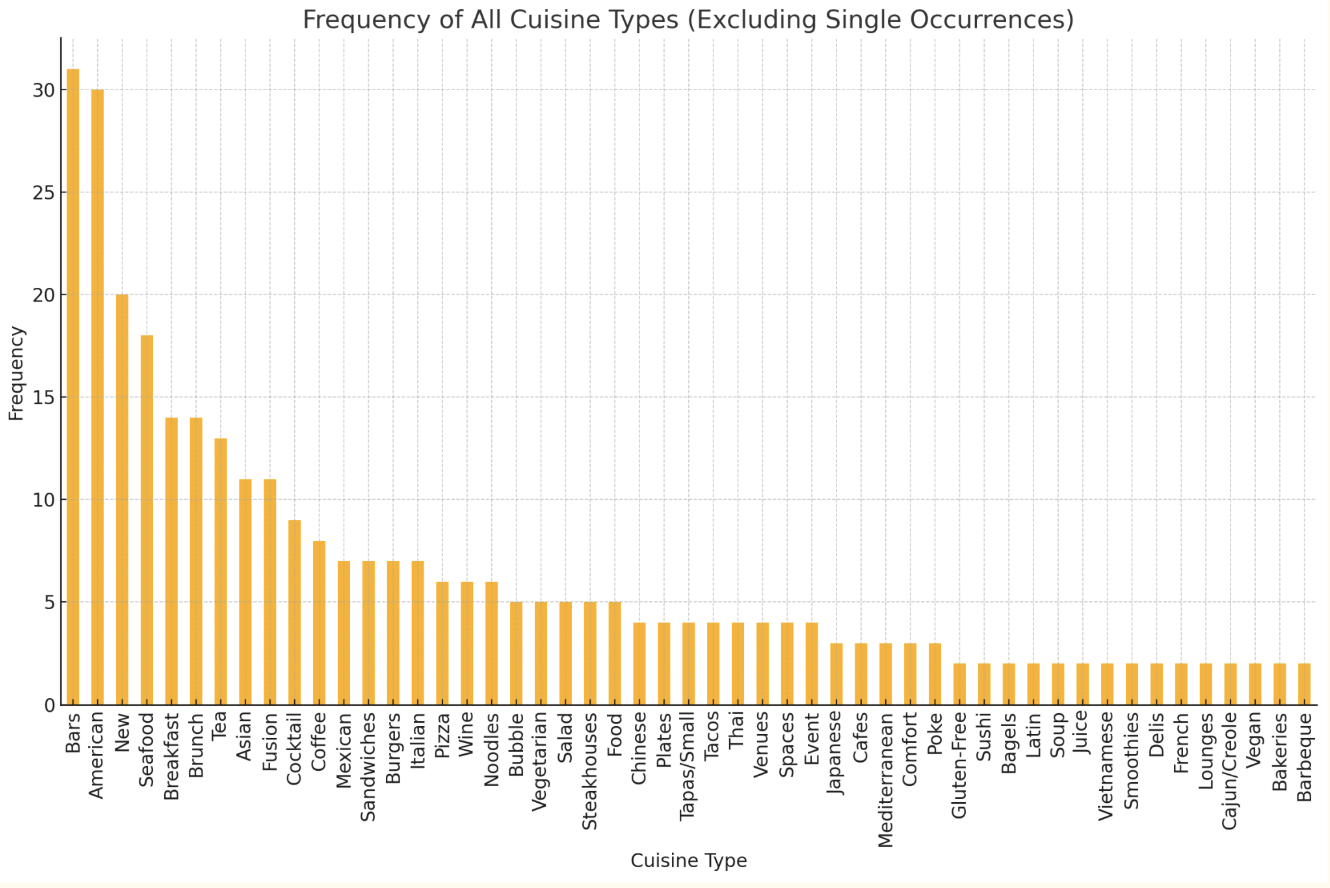

The bar chart interestingly shows the most common cuisines in the data set are actually general descriptions of the type of food served rather than actual cuisine. For example some of the top cuisines are “Seafood”, “Breakfast”, and “Brunch”. On top of some of the keywords describing the style of food served, most of the actual cuisines (“Mexican”, “Chinese”, etc) appear less than seven times in the data set. This may suggest that using those other keywords in a recommender system could give better recommendations than a system solely reliant on cuisine as the single input. 

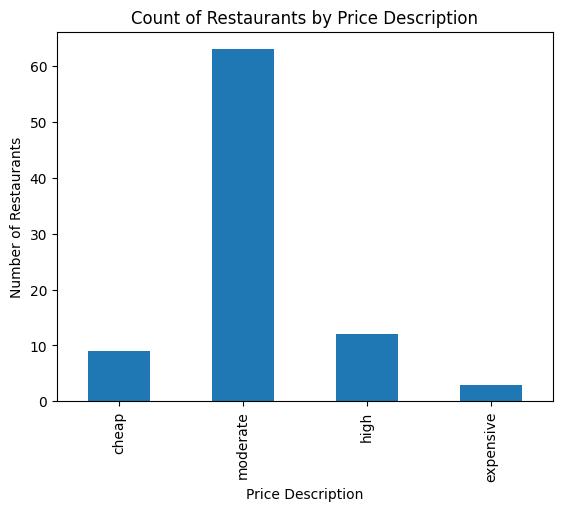

In [7]:
# Count of Restaurants by Price Description
restaurants_cleaned['price_descrip'].value_counts().reindex(['cheap', 'moderate', 'high', 'expensive']).plot(kind='bar')
plt.title('Count of Restaurants by Price Description')
plt.xlabel('Price Description')
plt.ylabel('Number of Restaurants')
plt.show()

The bar chart shows most of the restaurants in the data set are in the “moderate” price range. This makes sense as most restaurants have to cater to every-day people who aren’t going to spend a lot of money on one particular meal. However, this implies that our recommender system may work better when recommending moderately priced restaurants than other price brackets simply because there’s more places to choose from.

## Recommender Systems

With our cleaned data, we're ready to implement content-based recommender systems. With data only on the item-matrix, we are unable to do any collaborative-based recommender systems since we do not have the user-profile matrix.

We decided to test two different methods with one recommender using a bag of words vectorizer and another using Tf-IDF vectorizer.

### Bag of Words Recommender

The bag of words recommender system uses cosine similarity scores from a count vectorizer on the `descriptors` in addition to the price descriptions of the restaurants. These scores were used in the recommender system.

This system is completely NLP-based, as we only recommend restaurants based on simiar descriptions they may share from the `descriptors` variable. 

In [6]:
restaurants_cleaned['combined_features'] = restaurants_cleaned['descriptors'].fillna('') + ' ' + restaurants_cleaned['price_descrip'].fillna('')

count_vectorizer = CountVectorizer(stop_words='english')
count_matrix = count_vectorizer.fit_transform(restaurants_cleaned['combined_features'])
cosine_sim = cosine_similarity(count_matrix)

In [7]:
def recommend_restaurants(restaurant_name, top_n=5):
    # Get the index of the restaurant
    idx = restaurants_cleaned[restaurants_cleaned['name'] == restaurant_name].index[0]

    # Get pairwise similarity scores for the restaurant
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort restaurants by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top-n most similar restaurants
    sim_scores = sim_scores[1:top_n + 1]  # Exclude the restaurant itself

    # Get restaurant indices
    restaurant_indices = [i[0] for i in sim_scores]

    # Return the top-n most similar restaurants
    return restaurants_cleaned.iloc[restaurant_indices][['name', 'descriptors', 'price_descrip', 'rating']]

In [8]:
restaurant_name = "Zocalo"
top_recommendations = recommend_restaurants(restaurant_name, top_n=5)
print(top_recommendations)

                                     name  \
78                   Helena Avenue Bakery   
63                        The Shop Brunch   
46                            Super Cucas   
13                  On The Alley - Goleta   
37  Jeannine's American Bakery Restaurant   

                                          descriptors price_descrip  rating  
78          Bakeries  Breakfast & Brunch Coffee & Tea      moderate     4.3  
63      New American  Coffee & Tea Breakfast & Brunch      moderate     4.3  
46  Mexican Breakfast & Brunch Juice Bars & Smooth...      moderate     3.7  
13                      American Breakfast & Brunch        moderate     3.8  
37                            Coffee & Tea American        moderate     4.4  


Because this recommender system is soley based on NLP, it only finds similar restaurants based on the descriptions that Yelp labelled each restaurant with (such as cuisine type, foods offered, specialties). When we input "Zocalo", a Mexican restaurant in Isla Vista that is known for its breakfast menu (particularly its breakfast burrito) , we recieve recommendations of: "Helena Avenue Bakery", "The Shop Brunch", "Super Cucas", "On The Alley", and "Jeannine's American Bakery Restaurant." These recommendations are relevant in the sense that they are all breakfast/brunch food places or Mexican food. These similarites would be due to their descriptors having similar words relative to Mexican cuisine or breakfast food.

### TF-IDF Recommender
For our TF-IDF recommender, we incorporated similarites from the user input to the TF-IDF scores of the restaurant descriptors. Extending upon our NLP-based bag of words model, we also incorporated a weight system to account for price and rating similarities. 

In [ ]:
price_map = {'cheap': 1, 'moderate': 2, 'high': 3, 'expensive': 4}

restaurants_cleaned['Price_Numeric'] = restaurants_cleaned['price_descrip'].map(price_map).fillna(0)

restaurants_cleaned['Rating_Normalized'] = restaurants_cleaned['rating'] / restaurants_cleaned['rating'].max()

# Create a TfidfVectorizer instance and fit it on the restaurant data
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(restaurants_cleaned['descriptors'])

In [11]:
# Define a function to compute adjusted similarity considering price range and rating
def recommend_restaurants(user_input, tfidf_matrix, vectorizer, restaurant_data, preferred_price, top_n=5):
    # Transform the user input using the same vectorizer
    user_tfidf = vectorizer.transform([user_input])

    # Compute cosine similarity between the user input and restaurant data
    similarity_scores = cosine_similarity(user_tfidf, tfidf_matrix).flatten()

    # Adjust similarity based on price range
    preferred_price_numeric = price_map.get(preferred_price, 0)
    price_diff = abs(restaurant_data['Price_Numeric'] - preferred_price_numeric)
    price_penalty = 1 - (price_diff / max(price_map.values()))  # Scale to 0-1
    price_adjusted_scores = similarity_scores * price_penalty

    # Further adjust similarity based on ratings
    final_scores = price_adjusted_scores * restaurant_data['Rating_Normalized']

    # Get the top N restaurant indices sorted by final score
    top_indices = final_scores.argsort()[::-1][:top_n]

    # Get the top N restaurants with their final scores
    top_restaurants = [(restaurant_data.iloc[i], final_scores[i]) for i in top_indices]

    return top_restaurants

In [15]:
# Example user query and preferred price range
user_query = "chinese"
preferred_price = "moderate"

# Get top recommendations based on the user query, price range, and rating
top_recommendations = recommend_restaurants(user_query, tfidf_matrix, vectorizer, restaurants_cleaned, preferred_price)

# Display the top recommendations
print("Top restaurant recommendations:\n")
for i, (restaurant, score) in enumerate(top_recommendations):
    print(f"Rank {i + 1}: {restaurant['name']} (Score: {score:.2f})")
    print(f"Rating: {restaurant['rating']}, Reviews: {restaurant['num_reviews']}")
    print(f"Price Range: {restaurant['price_descrip']}\n")

Top restaurant recommendations:

Rank 1: Shang Hai (Score: 0.64)
Rating: 4.4, Reviews: 266.0
Price Range: moderate

Rank 2: Lao Wang (Score: 0.56)
Rating: 3.8, Reviews: 181.0
Price Range: moderate

Rank 3: China King (Score: 0.45)
Rating: 3.7, Reviews: 257.0
Price Range: moderate

Rank 4: Red Pepper Chinese Food Express (Score: 0.19)
Rating: 3.5, Reviews: 24.0
Price Range: nan

Rank 5: Mizza (Score: 0.00)
Rating: 4.0, Reviews: 609.0
Price Range: high



In [16]:
# Example user query and preferred price range
user_query = "italian"
preferred_price = "moderate"

# Get top recommendations based on the user query, price range, and rating
top_recommendations = recommend_restaurants(user_query, tfidf_matrix, vectorizer, restaurants_cleaned, preferred_price)

# Display the top recommendations
print("Top restaurant recommendations:\n")
for i, (restaurant, score) in enumerate(top_recommendations):
    print(f"Rank {i + 1}: {restaurant['name']} (Score: {score:.2f})")
    print(f"Rating: {restaurant['rating']}, Reviews: {restaurant['num_reviews']}")
    print(f"Price Range: {restaurant['price_descrip']}\n")

Top restaurant recommendations:

Rank 1: Bettina (Score: 0.58)
Rating: 4.2, Reviews: 655.0
Price Range: moderate

Rank 2: Toma Restaurant & Bar (Score: 0.57)
Rating: 4.5, Reviews: 1365.0
Price Range: high

Rank 3: Via Maestra 42 (Score: 0.53)
Rating: 4.3, Reviews: 807.0
Price Range: moderate

Rank 4: Ca' Dario - Goleta (Score: 0.42)
Rating: 4.0, Reviews: 282.0
Price Range: moderate

Rank 5: Convivo Restaurant and Bar (Score: 0.36)
Rating: 4.1, Reviews: 661.0
Price Range: moderate



In [15]:
# Example user query and preferred price range
user_query = "noodles burgers "
preferred_price = "cheap"

# Get top recommendations based on the user query, price range, and rating
top_recommendations = recommend_restaurants(user_query, tfidf_matrix, vectorizer, restaurants_cleaned, preferred_price)

# Display the top recommendations
print("Top restaurant recommendations:\n")
for i, (restaurant, score) in enumerate(top_recommendations):
    print(f"Rank {i + 1}: {restaurant['name']} (Score: {score:.2f})")
    print(f"Rating: {restaurant['rating']}, Reviews: {restaurant['num_reviews']}")
    print(f"Price Range: {restaurant['price_descrip']}\n")

Top restaurant recommendations:

Rank 1: Social Eats UCSB (Score: 0.53)
Rating: 4.7, Reviews: 3.0
Price Range: nan

Rank 2: Noodle City (Score: 0.34)
Rating: 3.7, Reviews: 590.0
Price Range: cheap

Rank 3: Empty Bowl Gourmet Noodle Bar (Score: 0.31)
Rating: 4.3, Reviews: 889.0
Price Range: moderate

Rank 4: Lao Wang (Score: 0.28)
Rating: 3.8, Reviews: 181.0
Price Range: moderate

Rank 5: Roof Top Bistro & Bar (Score: 0.26)
Rating: 3.8, Reviews: 145.0
Price Range: moderate



The TF-IDF recommender with cuisine scoring performs better than the bag of words that was soley NLP based. By the user requesting "italian" and "chinese", they receive relevant recommendations. As displayed, all of the "italian" recommendations are Italian restaurants: "Bettina", "Toma Restaurant & Bar", "Via Maestra 42", "Ca' Dario", and "Convivo Restaurant and Bar." 

This system was based upon allowing the user to input more than just a restaurant name to retrieve recommendations. This enables them to input other queries, such as what price range they are seeking, specific food items, and general cuisines. Our system applies a Tf-IDF vectorizer on both the user input and the item matrix. This enables cross similarity scoring between the two string datas. 

For instance, when the user inputs "noodles burgers", they are in theory requesting a restaurant that could offer both food items. While this may be unlikely for most restaurants to offer, our recommender system selects "Social Eats UCSB" as the most relevant restaurant recommendation, which in fact, is a restauarant that offers a food-court style menu that offers customers both noodles and burger menu items. The other restaurants following in the recommendation list may then pertain to either word, such as "Noodle City", "Empty Bowl", and "Lao Wang" for noodles and "Roof Top Bistro & Bar" for burgers. The order in which the noodle restaurants are recommended is dependent on the price range given by the user. Since the user was looking for "cheap" restuarnats, they are offered "Noodle City" before the other restaurants which are moderately priced.

Hence, we have built upon a system that works soley using NLP by incorporating price and rating adjustment weights. This edits the order of the recommendation list for the user, to optimize relevancy to the user search.

## Conclusion

The goal of this project was to solve the timeless problem of friends coming up with a place to eat together. The recommender systems we built do well in providing recommendations that match a couple words in `descriptors` but not the entire description. 

These results are proof that better, more elaborate systems with more variables could be built to improve recommendations to users. 

Some possible next steps for the project include:

- expand the list of restaurants to a larger area and factor the user location in determining relevant recommendations
- utilize the restaurant's hour/day availabilty to better refine the recommendations, based on the time of day or meal the user requests 
- tokenize user reviews to gather more descriptions for the restaurants; this would enable more features in our dataset, such as determining most popular food items, weekly specials, item prices, allergy notices, etc.
- create a collaborative-based recommender system that considers multiple users' preferences into account in determining a suitable restaurant pick for the overall group 